In [28]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Загрузка данных и их обработка

In [29]:
dt = pd.read_csv('SBER_190101_200101.txt', sep = ',')

In [30]:
data = dt.drop(['<TICKER>', '<PER>', '<TIME>', '<VOL>'], axis = 1)
data.head(5)

,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>
0,20190103,186.37,191.50,186.00,186.99
1,20190104,187.99,190.99,187.77,190.99
2,20190108,191.66,193.18,190.37,191.24
3,20190109,192.71,197.00,192.10,197.00
4,20190110,196.30,197.64,195.03,196.75


In [31]:
print(f'В выборке представлена информация об акциях Сбербанка за {data.shape[0]} торговых дня')

В выборке представлена информация об акциях Сбербанка за 252 торговых дня


Вычисление спреда по Роллу

In [32]:
data['delta Pt'] = data['<CLOSE>'].diff()
data['delta Pt-1'] = data['<CLOSE>'].diff().shift(periods = 1)

In [33]:
Rspread = 2*(-data.cov().loc['delta Pt','delta Pt-1'])**(0.5)

In [34]:
Rspread

1.6377752212993182

Расчеты по Глостену-Милгому

In [35]:
theta = 0.5
mu = 0.25
gamma = 0.5

In [36]:
vH = data['<HIGH>'].mean()
vL = data['<LOW>'].mean()

In [37]:
Prior_Exp = theta*vH + (1-theta)*vL

In [38]:
P_buy_vH = mu*1 + (1-mu)*gamma
P_buy_vL = mu*0 + (1-mu)*gamma

In [39]:
P_buy = P_buy_vH*theta + P_buy_vL*(1-theta)

In [40]:
P_vH_buy = P_buy_vH*theta/P_buy

In [41]:
Exp_buy = P_vH_buy*vH + (1-P_vH_buy)*vL
Exp_buy

227.5864136904761

In [42]:
P_vH_sell = (1-P_vH_buy)*theta/(1-P_buy)

In [43]:
Exp_sell = P_vH_sell*vH + (1-P_vH_sell)*vL
Exp_sell

226.57489583333324

Bid-ask спред

In [44]:
S = Exp_buy - Exp_sell
S

1.0115178571428487

In [45]:
#все предыдущие вычисления в виде функции
def GlMSpread(data, theta = 0.5, mu = 0.25, gamma = 0.5):
    
    vH = data['<HIGH>'].mean()
    vL = data['<LOW>'].mean()
    
    Prior_Exp = theta*vH + (1-theta)*vL
    P_buy_vH = mu*1 + (1-mu)*gamma
    P_buy_vL = mu*0 + (1-mu)*gamma
    P_buy = P_buy_vH*theta + P_buy_vL*(1-theta)
    
    P_vH_buy = P_buy_vH*theta/P_buy
    P_vH_sell = (1-P_vH_buy)*theta/(1-P_buy)
    
    Exp_buy = P_vH_buy*vH + (1-P_vH_buy)*vL
    Exp_sell = P_vH_sell*vH + (1-P_vH_sell)*vL
    
    S = Exp_buy - Exp_sell
    
    return S

In [46]:
d = {}

In [47]:
for mu in np.arange(0.2, 0.55, 0.05):
    d[round(mu, 2)]= GlMSpread(data, mu = mu)

In [48]:
d

{0.2: 0.8092142857142903,
 0.25: 1.0115178571428487,
 0.3: 1.213821428571407,
 0.35: 1.4161250000000223,
 0.4: 1.6184285714285522,
 0.45: 1.820732142857139,
 0.5: 2.0230357142856974}

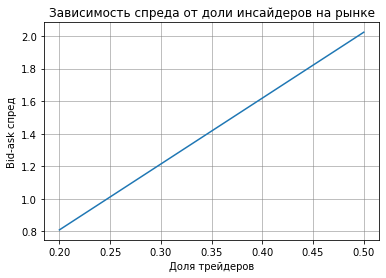

In [49]:
import matplotlib.pylab as plt

lists = sorted(d.items()) 
x, y = zip(*lists)

plt.plot(x, y)
plt.grid(color='grey', linestyle='-', linewidth=1, alpha = 0.5)
plt.title('Зависимость спреда от доли инсайдеров на рынке')
plt.xlabel('Доля трейдеров')
plt.ylabel('Bid-ask спред')
plt.show()

Расчеты по модели Кейла

In [50]:
dt = pd.read_csv('SBER_190101_200101.txt', sep = ',')
data = dt.drop(['<TICKER>', '<PER>', '<TIME>'], axis = 1)
data.head(5)

,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,20190103,186.37,191.50,186.00,186.99,40105780
1,20190104,187.99,190.99,187.77,190.99,32537090
2,20190108,191.66,193.18,190.37,191.24,38581950
3,20190109,192.71,197.00,192.10,197.00,70633230
4,20190110,196.30,197.64,195.03,196.75,56211650


In [51]:
data['delta Pt'] = data['<CLOSE>'].diff()
data['lambda'] = abs(data['delta Pt'])/data['<VOL>']
data['<DATE>'] = data['<DATE>'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

data.head(10)

,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,delta Pt,lambda
0,2019-01-03,186.37,191.50,186.00,186.99,40105780,NaN,NaN
1,2019-01-04,187.99,190.99,187.77,190.99,32537090,4.00,1.229366e-07
2,2019-01-08,191.66,193.18,190.37,191.24,38581950,0.25,6.479714e-09
3,2019-01-09,192.71,197.00,192.10,197.00,70633230,5.76,8.154802e-08
4,2019-01-10,196.30,197.64,195.03,196.75,56211650,-0.25,4.447477e-09
5,2019-01-11,197.13,198.96,195.61,196.80,63643670,0.05,7.856241e-10
6,2019-01-14,195.68,197.44,194.00,196.80,44643520,0.00,0.000000e+00
7,2019-01-15,197.39,198.84,195.91,198.00,52994790,1.20,2.264374e-08
8,2019-01-16,198.64,201.30,198.02,201.26,62392390,3.26,5.224996e-08
9,2019-01-17,201.67,203.55,201.05,203.32,59827610,2.06,3.443226e-08


In [52]:
data['lambda'].mean()

4.691234344719389e-08

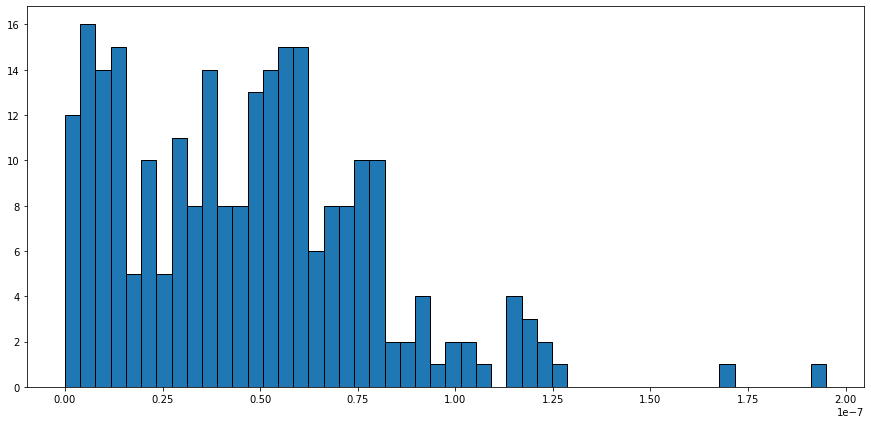

In [53]:
fig = plt.figure(figsize = (15, 7))
fig = plt.hist(data['lambda'], edgecolor = 'black', bins = 50)

plt.show()

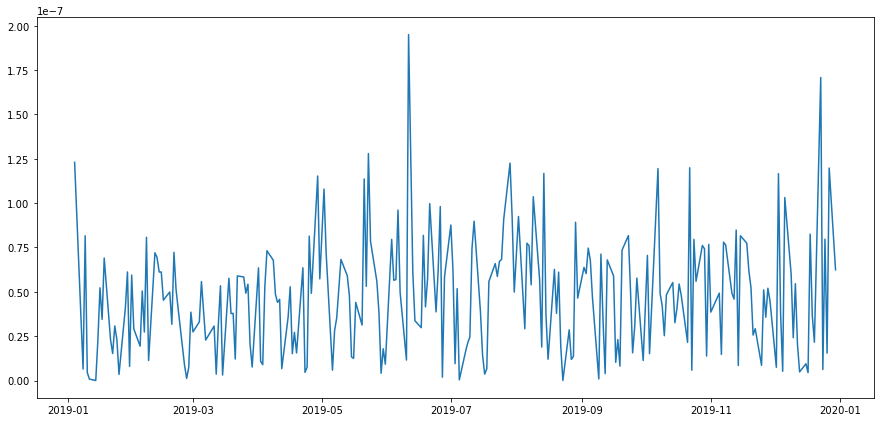

In [54]:
fig = plt.figure(figsize = (15, 7))
fig = plt.plot(data['<DATE>'], data['lambda'])

plt.show()